In [16]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
#root_dir = "D:/UoA_Research/data_10"
root_dir = "D:/740/calib_data/calib_data/calib_1024"
extr_param = {}

col = 8
row = 12
square_size = 43.
objp = np.zeros((col*row, 3), np.float32)
criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 30, 0.001)
objp[:, :2] = np.mgrid[0:col, 0:row].T.reshape(-1, 2) * square_size
intr_param = pickle.load(open('%s/intrinsic_param.pkl' % root_dir, 'rb'))
intr_param.keys()
extr_param = {}

In [20]:
cam_list = ['azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_1', 'kinect_v2_2']
start_idx = [0, 0, 0, 0, 0]
cam_R, cam_T, cam_M = [], [], []
n_list = [60, 60, 60, 40, 40]  # number of images

for idx, cam in enumerate(cam_list):
    print(cam)
    dir = "%s/%s_calib_snap" % (root_dir, cam)
    
    obj_points = []
    img_points_d = []
    img_points_c = []
    for i in range(n_list[idx]):
        flip = False
        filename = '%s/color%04i.jpg' % (dir, i + start_idx[idx])
        img_c = cv2.imread(filename)
        gray_c = cv2.cvtColor(img_c, cv2.COLOR_BGR2GRAY)
        ret_c, corners_c = cv2.findChessboardCorners(img_c, (col, row), None)
        
        filename = '%s/infrared%04i.png' % (dir, i + start_idx[idx])
        img_d = cv2.imread(filename, -1)
        for thr in [0.05, 0.02, 0.1]:
            gray_d = np.clip(img_d.astype(np.float32) * thr, 0, 255).astype('uint8')
            ret_d, corners_d = cv2.findChessboardCorners(gray_d, (col, row), None)
            if ret_d:
                break
                
        if ret_c and ret_d:
            obj_points.append(objp)
            corners2_d = cv2.cornerSubPix(gray_d, corners_d, (5, 5), (-1, -1), criteria)
            corners2_c = cv2.cornerSubPix(gray_c, corners_c, (5, 5), (-1, -1), criteria)
            
            cv2.drawChessboardCorners(img_c, (col, row), corners2_c, ret_c)
            cv2.imshow('img_c', cv2.resize(img_c, (int(img_c.shape[1]/2), int(img_c.shape[0]/2))))
            cv2.waitKey(50)
            
            cv2.drawChessboardCorners(gray_d, (col, row), corners2_d, ret_d)
            cv2.imshow('img_d', gray_d)
            cv2.waitKey(50)
            
            # flip
            vec_d = (corners2_d[0, 0, :] - corners2_d[-1, 0, :]) / np.linalg.norm(corners2_d[0, 0, :] - corners2_d[-1, 0, :])
            vec_c = (corners2_c[0, 0, :] - corners2_c[-1, 0, :]) / np.linalg.norm(corners2_c[0, 0, :] - corners2_c[-1, 0, :])
            if np.dot(vec_d, vec_c) < 0:
                # flip cn_c
                corners2_d = corners2_d[::-1, :]
                flip = True
    
            img_points_d.append(corners2_d)
            img_points_c.append(corners2_c)
        print(flip, ret_d, ret_c, filename)
        
    cv2.destroyAllWindows()
    print(len(obj_points), len(img_points_d), len(img_points_c))
    
    color_shape = (intr_param['%s_color' % cam][5], intr_param['%s_color' % cam][4]) # (w, h)
    
    mtx_d = np.array([[intr_param['%s_depth' % cam][0], 0, intr_param['%s_depth' % cam][2]],
                      [0, intr_param['%s_depth' % cam][1], intr_param['%s_depth' % cam][3]],
                      [0, 0, 1]])
    dist_d = intr_param['%s_depth' % cam][6:14]
    print(mtx_d, '\n', dist_d)

    mtx_c = np.array([[intr_param['%s_color' % cam][0], 0, intr_param['%s_color' % cam][2]],
                      [0, intr_param['%s_color' % cam][1], intr_param['%s_color' % cam][3]],
                      [0, 0, 1]])
    dist_c = intr_param['%s_color' % cam][6:14]
    print(mtx_c, '\n', dist_c)
    
    retval, _, _, _, _, R, T, _, _ = \
        cv2.stereoCalibrate(objectPoints=obj_points,
                            imagePoints1=img_points_d,
                            imagePoints2=img_points_c,
                            imageSize=color_shape,
                            cameraMatrix1=mtx_d,
                            distCoeffs1=dist_d,
                            cameraMatrix2=mtx_c,
                            distCoeffs2=dist_c,
                            criteria=(cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, 200, 1e-6),
                            flags=cv2.CALIB_FIX_INTRINSIC | cv2.CALIB_RATIONAL_MODEL)
    print("ret:\n", retval)
    print("R:\n", R)
    print("T:\n", T)
    cam_M.append([mtx_d, mtx_c, dist_d, dist_c])
    cam_R.append(R)
    cam_T.append(T)

    extr_param['%s_d2c' % cam] = (R, T)

azure_kinect_0
[[[ 62  95 114]
  [ 76 109 128]
  [ 83 113 130]
  ...
  [151 129 124]
  [151 129 124]
  [153 131 126]]

 [[ 82 115 134]
  [ 92 125 141]
  [ 94 124 141]
  ...
  [147 127 122]
  [149 127 122]
  [148 128 123]]

 [[ 85 118 134]
  [ 90 123 138]
  [ 89 120 135]
  ...
  [146 127 122]
  [147 127 122]
  [145 126 121]]

 ...

 [[ 90  98 105]
  [ 95 103 110]
  [ 96 102 107]
  ...
  [193  82  90]
  [195  83  91]
  [197  82  91]]

 [[ 89  97 104]
  [ 95 103 110]
  [ 96 102 107]
  ...
  [193  82  90]
  [194  82  90]
  [194  82  90]]

 [[ 90  98 105]
  [ 94 102 109]
  [ 93  99 104]
  ...
  [192  83  91]
  [194  82  90]
  [194  82  90]]]
False False False D:/740/calib_data/calib_data/calib_1024/azure_kinect_0_calib_snap/infrared0000.png
[[[ 54  90 108]
  [ 71 107 125]
  [ 80 113 132]
  ...
  [156 127 122]
  [155 126 121]
  [155 126 121]]

 [[ 81 117 135]
  [ 91 124 143]
  [ 89 122 141]
  ...
  [152 128 122]
  [154 128 122]
  [152 128 122]]

 [[ 83 117 133]
  [ 89 123 139]
  [ 88 121 137

In [3]:
# save
for k, v in extr_param.items():
    print(k, v)
with open('%s/kinect_extrinsic_param.pkl' % root_dir, 'wb') as f:
    pickle.dump(extr_param, f)



azure_kinect_0_d2c (array([[ 9.99998858e-01,  8.06783638e-04, -1.27755243e-03],
       [-6.74956529e-04,  9.94985107e-01,  1.00020901e-01],
       [ 1.35184087e-03, -1.00019925e-01,  9.94984516e-01]]), array([[-32.20522772],
       [ -2.42119739],
       [  0.17579252]]))
azure_kinect_1_d2c (array([[ 9.99999012e-01, -5.04062360e-04,  1.31225336e-03],
       [ 3.85370308e-04,  9.96038031e-01,  8.89274563e-02],
       [-1.35187923e-03, -8.89268627e-02,  9.96037241e-01]]), array([[-30.73790593],
       [ -2.35999357],
       [  0.57272411]]))
azure_kinect_2_d2c (array([[ 0.99999132,  0.00268298, -0.00318799],
       [-0.00240206,  0.99637192,  0.08507194],
       [ 0.00340467, -0.08506355,  0.99636971]]), array([[-32.84477816],
       [ -1.80536666],
       [ -1.0126389 ]]))
kinect_v2_1_d2c (array([[ 0.99997611, -0.00295257, -0.00624923],
       [ 0.00296989,  0.99999177,  0.00276371],
       [ 0.00624102, -0.00278221,  0.99997665]]), array([[ -0.75650233],
       [-51.88390885],
       [

azure_kinect_0
[[503.06639099   0.         311.33891831]
 [  0.         503.21108056 321.93624221]
 [  0.           0.           1.        ]] 
 [[428.68066406   0.         309.78454516]
 [  0.         441.24032593 331.07728759]
 [  0.           0.           1.        ]]
[[9.76783835e+02 0.00000000e+00 1.00070160e+03]
 [0.00000000e+00 9.76695470e+02 7.84699570e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 
 [[1.01752979e+03 0.00000000e+00 9.72912676e+02]
 [0.00000000e+00 1.03411792e+03 7.84970642e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[ 9.99998875e-01  7.93958731e-04 -1.27245236e-03 -3.22135698e+01]
 [-6.62693642e-04  9.94984194e-01  1.00030065e-01 -2.43074058e+00]
 [ 1.34548973e-03 -1.00029109e-01  9.94983601e-01  1.67975726e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
azure_kinect_1
[[502.43212671   0.         310.18844369]
 [  0.         502.70714123 337.1785767 ]
 [  0.           0.           1.        ]] 
 [[427.15319824   0.     

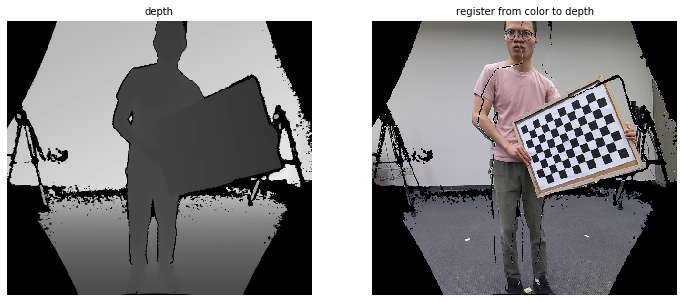

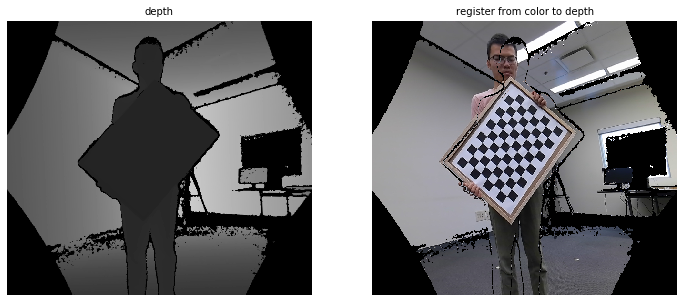

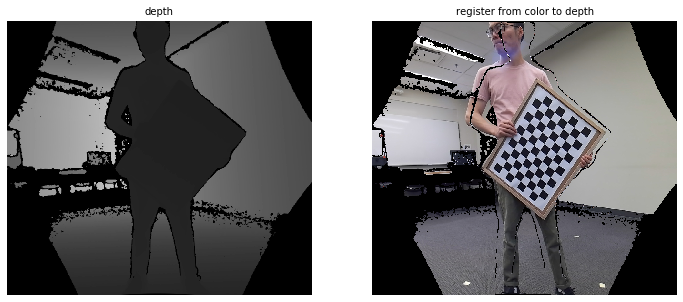

In [8]:
i = 20
for idx, cam in enumerate(cam_list):
    print(cam)
    # registration depth2color azure kinect 0
    dir = "%s/%s_calib_snap" % (root_dir, cam)
    # dir = 'D:/UoA_Research/data_2/2/%s' % cam

    frame_idx = i + start_idx[idx]
    
    mtx_d, mtx_c, dist_d, dist_c = cam_M[idx]

    depth_dis = cv2.imread('%s/depth%04i.png' % (dir, frame_idx), -1)
    # depth_img = cv2.undistort(depth_dis, mtx_d, dist_d)
    h,  w = depth_dis.shape[:2]
    new_mtx_d, _ = cv2.getOptimalNewCameraMatrix(mtx_d, dist_d, (w,h), 0, (w,h))
    depth_img = cv2.undistort(depth_dis, mtx_d, dist_d, None, new_mtx_d)
    print(mtx_d, '\n', new_mtx_d)

    # plt.figure(figsize=(12, 12))
    # plt.subplot(121)
    # plt.imshow(depth_dis, cmap='gray')
    # plt.axis('off')
    # plt.title('depth', fontsize=20)
    #
    # plt.subplot(122)
    # plt.imshow(depth_img, cmap='gray')
    # plt.axis('off')
    # plt.title('undistorted depth', fontsize=20)
    # plt.show()
    
    rgb_dis = cv2.cvtColor(cv2.imread('%s/color%04i.jpg' % (dir, frame_idx)), cv2.COLOR_BGR2RGB)
    # rgb_img = cv2.undistort(rgb_dis, mtx_c, dist_c)
    h,  w = rgb_dis.shape[:2]
    new_mtx_c, _ = cv2.getOptimalNewCameraMatrix(mtx_c, dist_c, (w,h), 0, (w,h))
    rgb_img = cv2.undistort(rgb_dis, mtx_c, dist_c, None, new_mtx_c)
    print(mtx_c, '\n', new_mtx_c)

    # plt.figure(figsize=(12, 12))
    # plt.subplot(121)
    # plt.imshow(rgb_dis)
    # plt.axis('off')
    # plt.title('depth', fontsize=20)
    #
    # plt.subplot(122)
    # plt.imshow(rgb_img)
    # plt.axis('off')
    # plt.title('undistorted rgb', fontsize=20)
    # plt.show()

    K_depth = np.eye(4)
    K_depth[0:3, 0:3] = new_mtx_d

    K_color = np.eye(4)
    K_color[0:3, 0:3] = new_mtx_c

    # depth to color
    R = cam_R[idx]
    T = cam_T[idx]
    M = np.eye(4)
    M[0:3, 0:3] = R
    M[0:3, 3] = np.squeeze(T)
    H = np.dot(np.dot(K_color, M), np.linalg.inv(K_depth))
    print(M)
    
    V, U = depth_img.shape
    V_c, U_c, _ = rgb_img.shape
    
    # color to depth
    depth_register = np.zeros([V, U, 3], dtype=np.uint8)
    for v in range(V):
        for u in range(U):
            d = depth_img[v, u]
            if d != 0:
                u_rgb = np.dot(H[0, :], np.array([u, v, 1., 1. / d]))
                v_rgb = np.dot(H[1, :], np.array([u, v, 1., 1. / d]))
                if 0 < u_rgb < U_c and 0 < v_rgb < V_c:
                    depth_register[v, u, :] = rgb_img[int(v_rgb), int(u_rgb), :]
    
    plt.figure(figsize=(12, 12))
    plt.subplot(121)
    plt.imshow(depth_img, cmap='gray')
    plt.axis('off')
    plt.title('depth', fontsize=10)
    
    plt.subplot(122)
    plt.imshow(depth_register)
    plt.axis('off')
    plt.title('register from color to depth', fontsize=10)
    plt.show()



In [3]:
import pickle
import matplotlib.pyplot as plt
from Calibration.utils import *
root_dir = "D:/UoA_Research/data_10"
intr_param = pickle.load(open('%s/intrinsic_param.pkl' % root_dir, 'rb'))
print(intr_param.keys())
extr_param = pickle.load(open('%s/kinect_extrinsic_param.pkl' % root_dir, 'rb'))
print(extr_param.keys())
cam_list = ['azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_1', 'kinect_v2_2']

dict_keys(['azure_kinect_0_color', 'azure_kinect_0_depth', 'azure_kinect_1_color', 'azure_kinect_1_depth', 'azure_kinect_2_color', 'azure_kinect_2_depth', 'kinect_v2_1_color', 'kinect_v2_1_depth', 'kinect_v2_2_color', 'kinect_v2_2_depth', 'event_camera', 'polar'])
dict_keys(['azure_kinect_0_d2c', 'azure_kinect_1_d2c', 'azure_kinect_2_d2c', 'kinect_v2_1_d2c', 'kinect_v2_2_d2c'])


azure_kinect_0
azure_kinect_1
azure_kinect_2
kinect_v2_1
kinect_v2_2


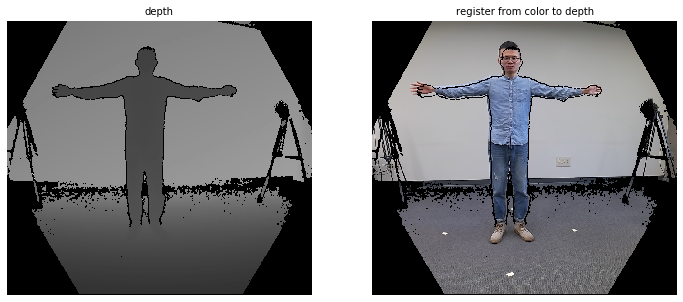

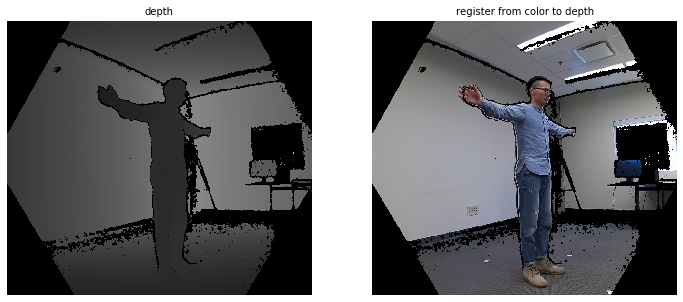

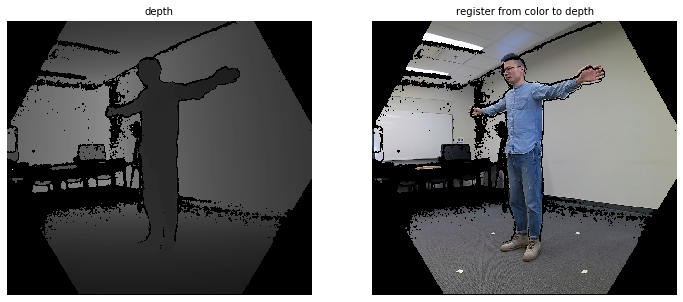

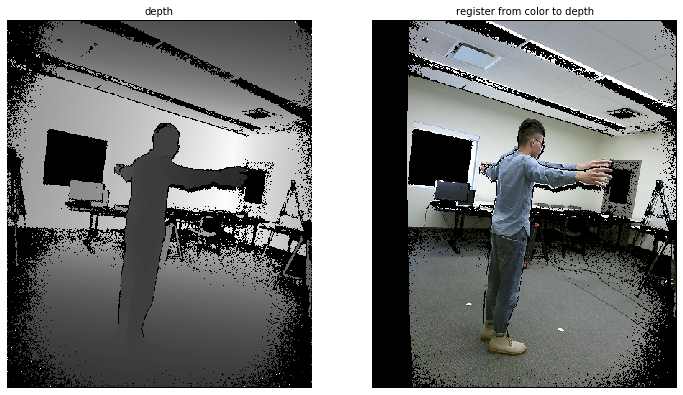

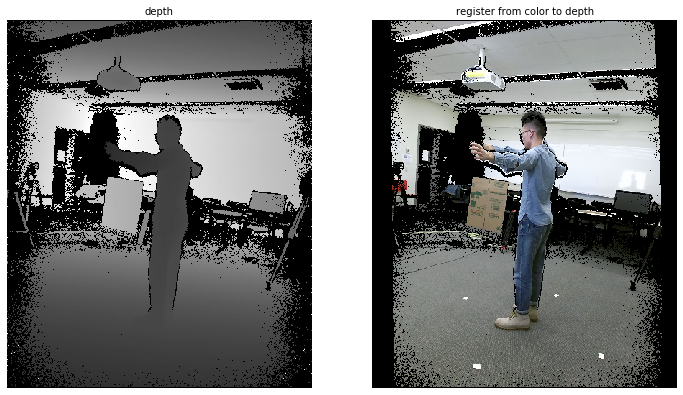

In [7]:
ii = 0
for idx, cam in enumerate(cam_list):
    print(cam)
    # registration depth2color azure kinect 0
    dir = "%s/%s_calib_snap" % (root_dir, cam)

    frame_idx = ii
    
    R, t = extr_param['%s_d2c' % cam]
    
    depth_img = cv2.imread('%s/1/%s/depth/depth%04i.png' % (root_dir, cam, frame_idx), -1)
    rgb_img = cv2.cvtColor(cv2.imread('%s/1/%s/color/color%04i.jpg' % (root_dir, cam, frame_idx)), cv2.COLOR_BGR2RGB)
    
    V, U = depth_img.shape
    V_c, U_c, _ = rgb_img.shape
    
    uvd_d = depth2uvd(depth_img).reshape([V * U, 3])
    cam_param = intr_param['%s_depth'% cam]
    xyz_d = unprojection(uvd_d, cam_param, False)
    
    xyz_c = (np.dot(R, xyz_d.T) + t).T
    cam_param = intr_param['%s_color'% cam]
    uvd_c = projection(xyz_c, cam_param, True)
    
    # color to depth
    depth_register = np.zeros([V, U, 3], dtype=np.uint8)
    for i in range(V * U):
        u = uvd_d[i, 0]
        v = uvd_d[i, 1]
        u_rgb = uvd_c[i, 0]
        v_rgb = uvd_c[i, 1]
        if 0 < u_rgb < U_c and 0 < v_rgb < V_c and uvd_d[i, 2] > 0:
            depth_register[int(v), int(u), :] = rgb_img[int(v_rgb), int(u_rgb), :]
    
    plt.figure(figsize=(12, 12))
    plt.subplot(121)
    plt.imshow(depth_img, cmap='gray')
    plt.axis('off')
    plt.title('depth', fontsize=10)
    
    plt.subplot(122)
    plt.imshow(depth_register)
    plt.axis('off')
    plt.title('register from color to depth', fontsize=10)
    plt.show()
    
    